In [7]:
from IORlib.utils import ceildiv
import matplotlib.pyplot as pl
%matplotlib widget

def figures(*keywords, ncols=1):
    # Create figure and axes
    nplots = len(keywords)
    nrows = ceildiv(nplots, ncols)
    fig = pl.figure(figsize=(8*ncols, 4*nrows))
    axes = {key:fig.add_subplot(nrows, ncols, i+1) for i,key in enumerate(keywords)}
    fig.subplots_adjust(hspace=0.5, wspace=0.25)
    return axes

In [8]:
def dQ(phase, cell):
    I,J,K = [f'flr{phase}{d}' for d in ('i','j','k')]
    dQx = getattr(cell,I)[:,2:, : ,:] - getattr(cell,I)[:,:-2,:  ,:  ]
    dQy = getattr(cell,J)[:, :,2:, :] - getattr(cell,J)[:,:  ,:-2,:  ] 
    dQz = getattr(cell,K)[:, :, :,2:] - getattr(cell,K)[:,:  ,:  ,:-2]
    return (dQx[:,  :  , 1:-1, 1:-1] + 
            dQy[:, 1:-1,  :  , 1:-1] + 
            dQz[:, 1:-1, 1:-1,  :  ])

def dS_from_saturation(cell):
    D = {}
    soil = 1 - cell.swat - cell.sgas
    D['dSo'] = soil[1:,...] - soil[:-1,...]
    D['dSw'] = cell.swat[1:,...] - cell.swat[:-1,...]
    D['dSg'] = cell.sgas[1:,...] - cell.sgas[:-1,...]
    return D

def dS_from_dQ(cell):
    dt = cell.days[1:] - cell.days[:-1]
    D = {}
    for phase in ('oil', 'wat', 'gas'):
        dQph = dQ(phase, cell)
        D['dV'+phase[0]] = (dt[:,None,None,None] * dQph[1:,...])/cell.rporv[1:,1:-1,1:-1,1:-1] 
    return D
   

In [2]:
from collections import namedtuple
from itertools import islice
from IORlib.ECL import UNRST_file
from IORlib.utils import take
from pathlib import Path

home = Path.home()
shared = Path('/home/shared/owner')
root = shared/'CoP_files/input/IORSIM_BASECASE/IORSIM_BASECASE_INPUT'
#root = home/'github/IORSim_GUI/cases/L18_FWD/L18_FWD'
#root = shared/'norne/NORNE_INTERSECT'
unrst = UNRST_file(root)
#unrst.count_sections()
%timeit next(unrst.cellarray('SWAT', 'SGAS', 'RPORV', 'FLR???[IJK]+'));
#%timeit unrst.cellarray2('SWAT', 'SGAS', 'RPORV', 'FLR???[IJK]+');
#D = dict(**dS_from_dQ(cell), **dS_from_saturation(cell))

# 4.38 s ± 5.82 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

4.38 s ± 5.82 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


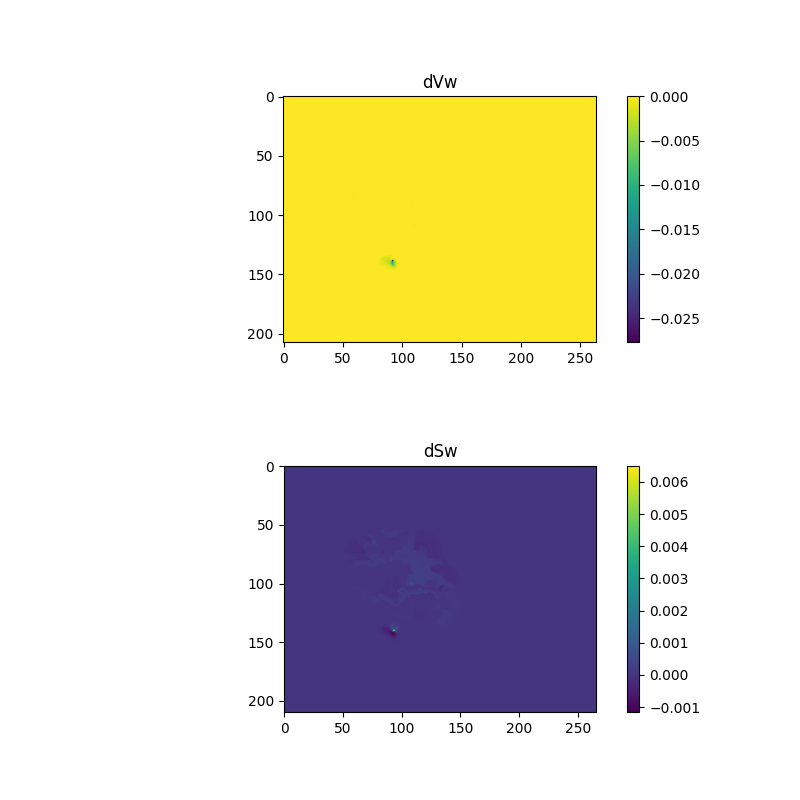

In [10]:
#soil.shape
#pl.figure()
#pl.imshow(soil[:,:,14,0]), pl.colorbar()
for var,fig in figures('dVw', 'dSw').items():
    fig.set_title(var)
    im = fig.imshow(D[var][0,:,:,1])
    pl.colorbar(im)
